Установка необходимых библиотек

In [ ]:
# !pip install catboost
# !pip install xgboost
# !pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, mean_squared_error, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

import warnings

Подключение к google disk, где хранятся таблицы


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Цель данной работы предсказание дефолта клиента. 

##### **application_train.csv** и **application_test**.csv хранят тренировочные и тестовые данные, для которых я буду предсказывать просрочку/не возрат кредита (*У = 1*) и отсувствие проблем по платежам (*У=0*)

##### Train содержит признак **TARGET** - целевой столбец

##### Test содержит те же признаки, что и train, за исключением TARGET

##### Задача предсказать бинарный класс клиента. Буду использовать модели классификации

# EDA

In [ ]:
# Загрузка тренировочных данных
app_train = pd.read_csv('drive/MyDrive/Data/application_train.csv')

In [ ]:
# Загрузка таблицы, в которой хранится описание каждого столбца
description = pd.read_csv('drive/MyDrive/Data/HomeCredit_columns_description.csv', encoding= 'windows-1251')

### Предварительный анализ application_train.csv (далее train, для удобства)

In [ ]:
app_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


##### Избавимся от дубликатов,т.к. они не несут ценность для предсказательной способности модели 

In [ ]:
# дубликатов нет
app_train.duplicated().sum()

0

Необходимо проверить сбалансированность классов

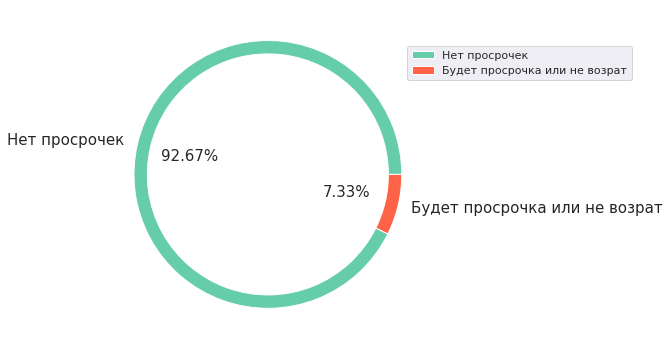

In [ ]:
labels = ['Нет просрочек', 'Будет просрочка или не возрат']
x=[app_train[app_train['TARGET'] == 0]['TARGET'].count(), app_train[app_train['TARGET'] == 1]['TARGET'].count()]
fig1, ax1 = plt.subplots(figsize=(6, 9))
wedges, texts, autotexts = ax1.pie(
    x,
    labels=labels,
    autopct='%1.2f%%',
    colors = ['mediumaquamarine','tomato'],
    textprops={'fontsize': 15},
    wedgeprops=dict(width=0.1, edgecolor='w'))

ax1.legend(loc='upper left', bbox_to_anchor=(.9, .9))
plt.show()

#### Фиксирую **несбалансированость** классов. Необходимо это учесть и решить данную проблему

In [ ]:
print(f' rows: {app_train.shape[0]} columns: {app_train.shape[1]}')

 rows: 307511 columns: 122


In [ ]:
# Функция для подсчета пропущенных значений внутри каждого столбца
def missing_values_table(df,flag,percent):
    
        # Всего недостает
        mis_val = df.isnull().sum()
        
        # Процент недостающих данных
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Таблица с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименование столбцов
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировка про процентажу
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        
        l = list(mis_val_table_ren_columns[mis_val_table_ren_columns['% of Total Values']>percent]['Missing Values'].index)

        
        if flag == True:
        

          return l
          # Возврат списка столбцов, с пропуском выше percent (подаем как аргумент)


        else:
        

          return mis_val_table_ren_columns
          # Возврат таблицы с со всеми столбцами, где есть пропуск

missing_list = missing_values_table(app_train,True, 50)
# возращает все значения, где пропусков больше 50% от всего объема

Сразу же удалю признаки, которые содержат более 50% пропусков, а остальные заполню или дропну

In [ ]:
# кол. столбцов до удаления
app_train.shape[1]

122

In [ ]:
app_train = app_train.drop(missing_list,axis = 1)

In [ ]:
# кол. столбцов после
app_train.shape[1]

81

Пока что заполню пустые значения медианой или самым популярным для категориальных данных

In [ ]:
# Список категориальных столбцов
categorical_columns =[column for column in app_train.columns if app_train[column].dtype == 'object']
# Список числовых столбцов
numerical_columns =[column for column in app_train.columns if app_train[column].dtype != 'object']

Перед тем как заполнить, узнаю из документации значение каждого столбца

In [ ]:
app_train[categorical_columns].head(1)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,No


In [ ]:
app_train.NAME_FAMILY_STATUS.unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

In [ ]:
print(f"Количество строк, содержащие значения Unknown: {app_train[app_train['NAME_FAMILY_STATUS']=='Unknown'].shape[0]}")

Количество строк, содержащие значения Unknown: 2


#####  Из признака **NAME_FAMILY_STATUS** необходимо удалить строки, содержащие значение *unknown*, т.к. нет смысла в проверке гипотез и выявление связей семейного статуса с иными фичами для людей, для которых просто не удалось узнать семейный статус. К тому же, в моем случае таких строк всего 2 и их удаление стастистически не исказаит природу данных

In [ ]:
# Перед и после выполнения той или иной ячейки, я буду часто фиксировать измненения  
app_train.shape[0], app_train.shape[1]

(307511, 81)

In [ ]:
app_train = app_train[app_train['NAME_FAMILY_STATUS'] != 'Unknown']

In [ ]:
app_train.shape[0], app_train.shape[1]

(307509, 81)

#### Заполню категориальные признаки самым популярным значением в столбце

###### (В дипломной работе я рассмотрю иные алгоритмы заполнение пропусков)

In [ ]:
# Выявление столбцов для заполнения
app_train[categorical_columns].isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1290
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
EMERGENCYSTATE_MODE           145754
dtype: int64

In [ ]:
# Словарь, который хранит самое распространенное значение для каждого столбца, который я хочу заполнить
dict_pop = {'NAME_TYPE_SUITE':app_train['NAME_TYPE_SUITE'].value_counts().sort_values(ascending = False).index[0],
             'OCCUPATION_TYPE':app_train['OCCUPATION_TYPE'].value_counts().sort_values(ascending = False).index[0],
             'EMERGENCYSTATE_MODE':app_train['EMERGENCYSTATE_MODE'].value_counts().sort_values(ascending = False).index[0]}

In [ ]:
dict_pop

{'EMERGENCYSTATE_MODE': 'No',
 'NAME_TYPE_SUITE': 'Unaccompanied',
 'OCCUPATION_TYPE': 'Laborers'}

In [ ]:
# Заполнение пропусков
app_train = app_train.fillna(value = dict_pop)

In [ ]:
# Проверка работы кода выше
app_train[categorical_columns].isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
EMERGENCYSTATE_MODE           0
dtype: int64

Перейду к числовым значениям

In [ ]:
app_train[numerical_columns].head(1)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


##### Исключаю: **DAYS_ID_PUBLISH**
##### За сколько дней до подачи заявления клиент изменил документ, удостоверяющий личность, с которым он обращался за кредитом.
##### Даты смены паспорта могут хранить инсайды, а в частности колчество дат смены документа минус количества дат смены паспорта, установленых законодательно. Возможно, заемщик, который терял паспорт более N раза является не надежным, так как не серьезно относится к своим документам и я могу предположить, что отношение к срокам погашения и в целом к возрату заемных средст тоже не серьезное. Однако, он мог восстанавливать паспорт и по другим причинам, возможно, есть клиенты, которые теряли документ не по своей вине. Нужны данные и проводить ислледование, пока это гипотеза.
##### В данном случае тут просто 1 дата и с высоты своего опыта, я не вижу смысла оставлять данные признак в исследование

In [ ]:
app_train.shape[0], app_train.shape[1]

(307509, 81)

In [ ]:
app_train = app_train.drop('DAYS_ID_PUBLISH', axis = 1)

In [ ]:
app_train.shape[0], app_train.shape[1]

(307509, 80)

In [ ]:
# Удалю признак из списка числовых столбцов, чтобы далее корректно использовать данный список
numerical_columns.remove('DAYS_ID_PUBLISH')

### Удаление аномалий

Необхоимо удалить аномалии и/или выбросы, т.к. задача модели выявить типичное поведение. Аномалии и выбросы способны ввести модели в заблуждение

Перед тем, как начать поиск аномальных значений, исключу из списка числовых признаков флаговые значения (предоставил документ 1 (да) или 0 (нет)), бинанрные значения и другие на мое усмотрение


In [ ]:
# создание списка, который будет хранить числовые признаки, для которых необходимо почистить аномалии и выбросы
numerical_columns_anomal = []

In [ ]:
# Исключу столбцы с бинарными столбцами 
for feature in app_train[numerical_columns].columns:
  if len(app_train[feature].unique().tolist()) != 2:
    numerical_columns_anomal.append(feature)

In [ ]:
# убеждаюсь, что numerical_columns_anomal после исполнения ячейки стал меньше 
len(numerical_columns),len(numerical_columns_anomal)

(67, 34)

In [ ]:
# исключу SK_ID_CURR (id кредита)
numerical_columns_anomal.remove('SK_ID_CURR')

In [ ]:
len(numerical_columns_anomal)

33

Полный анализ поиска аномалий и выбросов я провел, построив boxplot для всех столбцов, но продемострирую лишь несколько графиков из 34

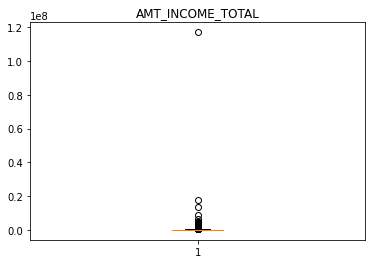

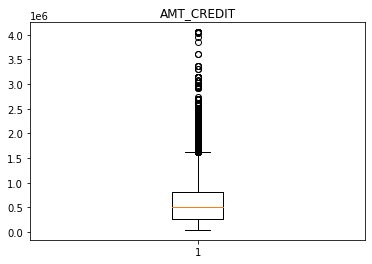

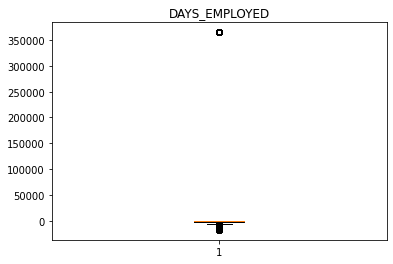

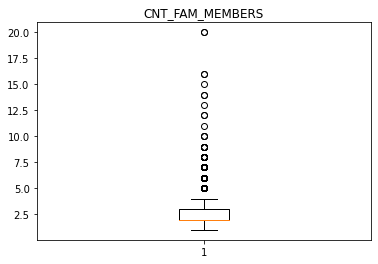

In [ ]:
warnings.filterwarnings('ignore')
# вывожу boxplots только для 4 столбцов среди столбцов, которые я поместил в список для поиска аномалий
for col in app_train[numerical_columns_anomal][app_train[numerical_columns_anomal].columns[[1,2,7,9]]]: 
 fig1, ax1 = plt.subplots()
 ax1.set_title(col)
 ax1.boxplot(app_train[col])


При рассмотрение боксплотов я нашел еще столбцы, которые не стоит рассматривать далее в рамках данного этапа работы

**DAYS_BIRH** - аномалий не обнаружено
**EXT_SOURCE_2** и **EXT_SOURCE_2** - это оценка заемщика из внешних источников (команий, которые специлизируются на оценки клиента для банков). Значения ∈ (0;1). Понимаю, что с точки зрения статистики данные столбцы можгу обладать аномальными значениями. Но я предполагаю, что они окажут огромный вклад в предсказание целефой фичи, и не хотелось бы лишаться полезной инфомации.

In [ ]:
len(numerical_columns_anomal)

33

In [ ]:
numerical_columns_anomal.remove('DAYS_BIRTH')
numerical_columns_anomal.remove('EXT_SOURCE_2')
numerical_columns_anomal.remove('EXT_SOURCE_3')

In [ ]:
len(numerical_columns_anomal)

30

Также, исключу из списка аномальных столбцов **REGION_RATING_CLIENT** - внутрений рейтинг банка, так как там всего 3 значения.

In [ ]:
app_train.REGION_RATING_CLIENT.unique()

array([2, 1, 3])

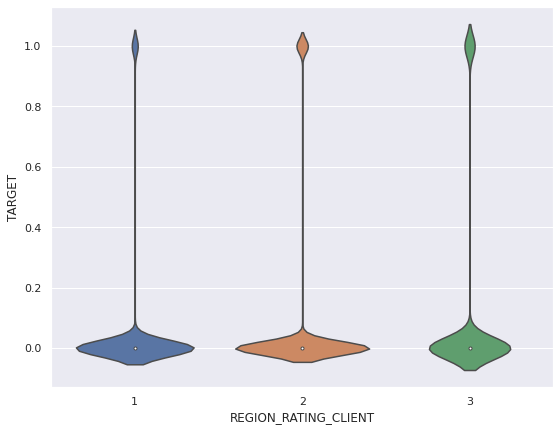

In [ ]:
# Хотел узнать распределение значений по целелевой переменной
sns.set(rc={'figure.figsize':(9,7)});
sns.violinplot(x="REGION_RATING_CLIENT", y="TARGET", data=app_train);

Удалю **REGION_RATING_CLIENT_W_CITY** по аналогичной причине

In [ ]:
len(numerical_columns_anomal)

30

In [ ]:
#В ячейке выше указано, что нет смысла искать аномалии у некоторых столбцов, ислючу их
numerical_columns_anomal.remove('REGION_RATING_CLIENT')
numerical_columns_anomal.remove('REGION_RATING_CLIENT_W_CITY')

In [ ]:
len(numerical_columns_anomal)

28

Аномалии/выбросы есть у : 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',AMT_REQ_CREDIT_BUREAU_MON,'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR' (для всех этих значений построить hist), DAYS_LAST_PHONE_CHANGE,'DEF_60_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE',OBS_30_CNT_SOCIAL_CIRCLE,'TOTALAREA_MODE','FLOORSMAX_MEDI','YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MODE','YEARS_BEGINEXPLUATATION_MODE','FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_AVG',

Посмотрим гистограммы

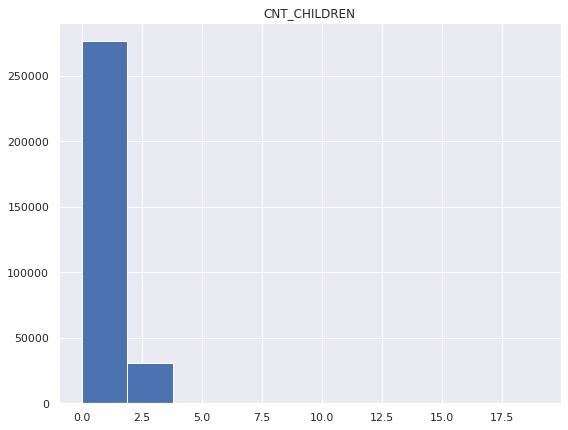

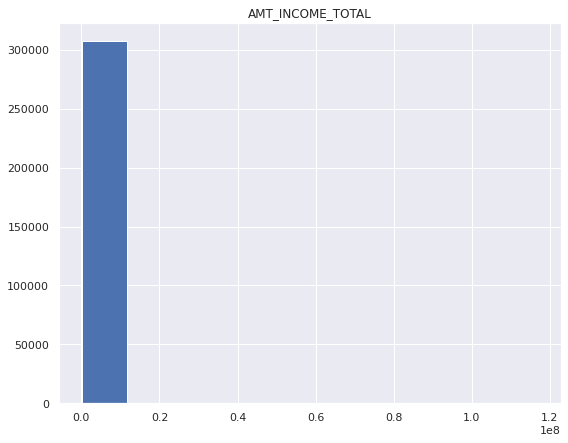

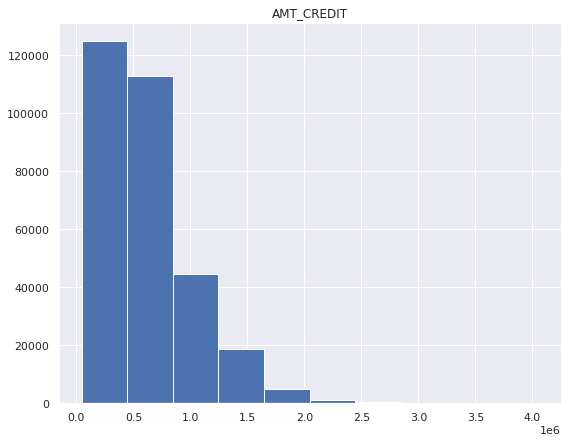

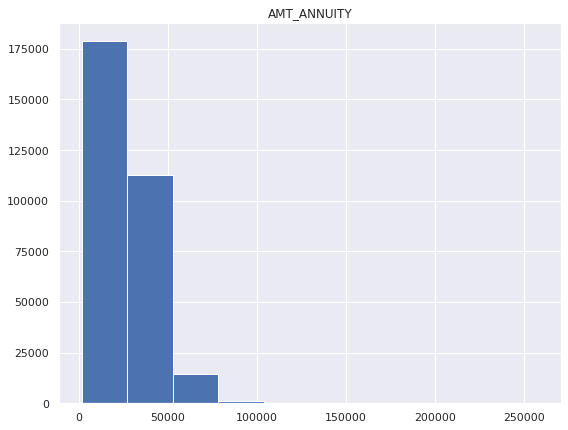

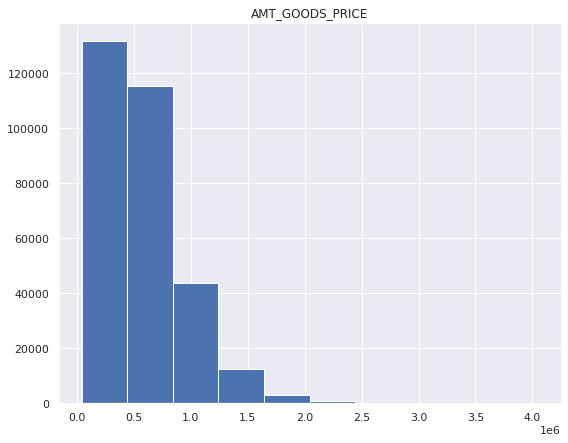

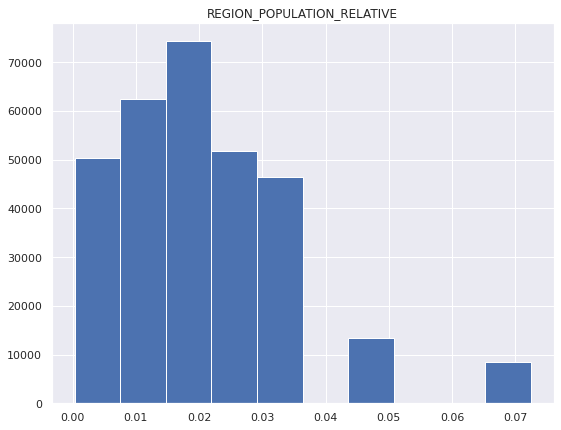

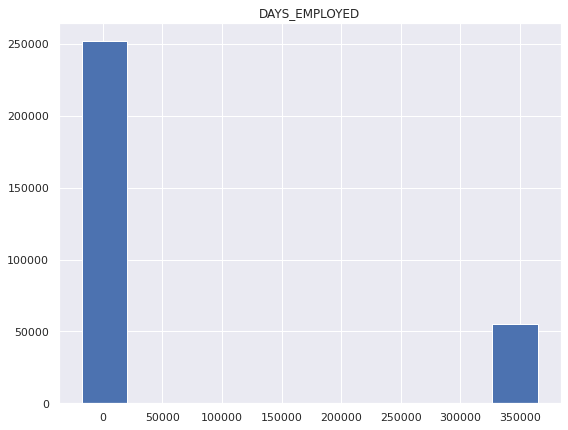

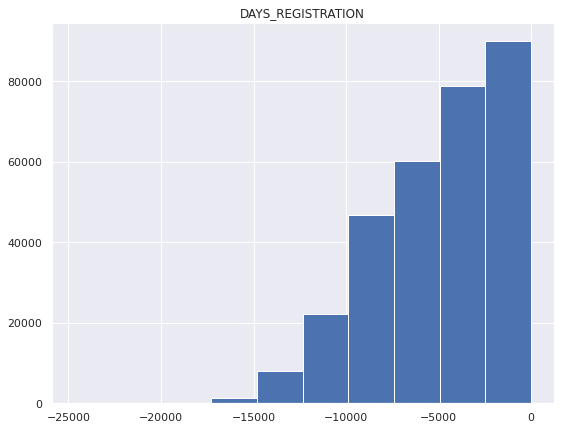

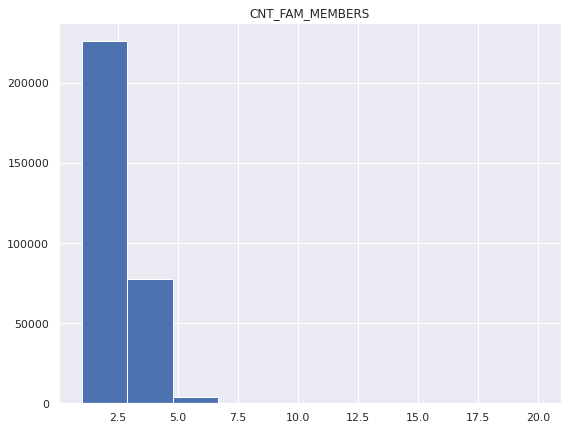

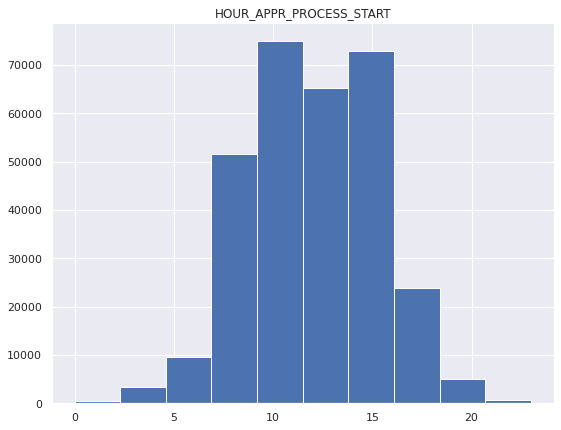

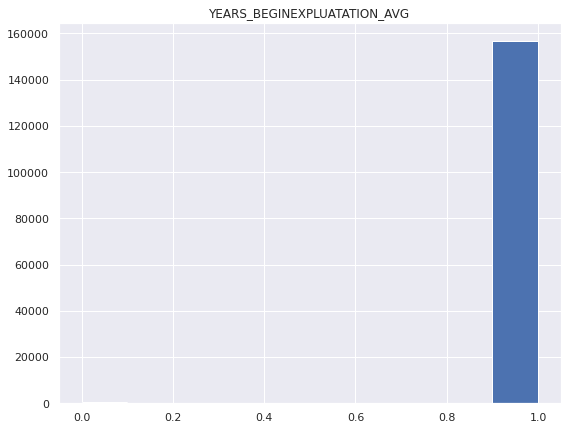

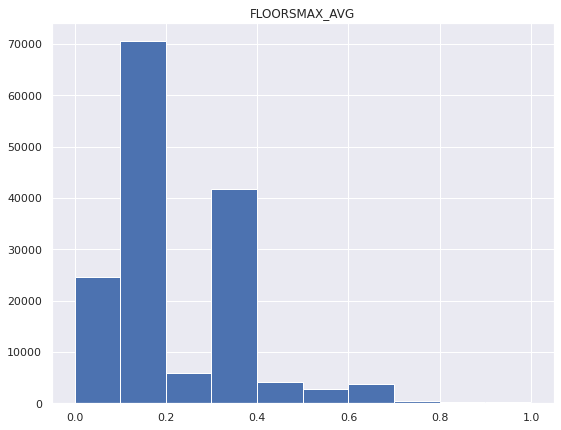

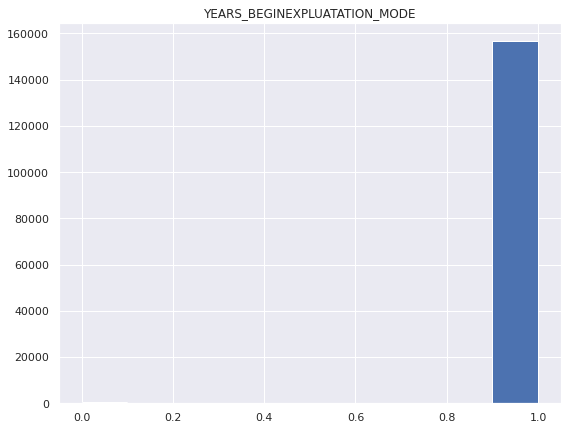

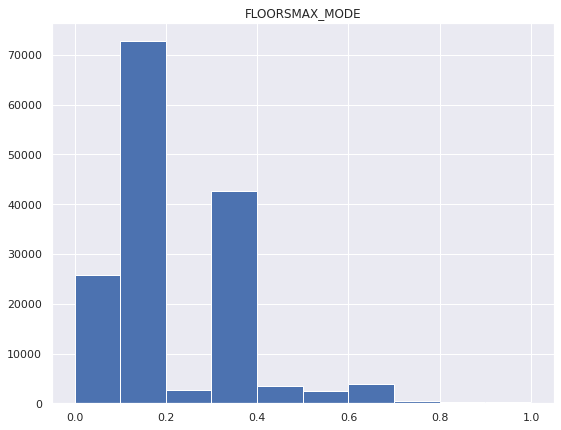

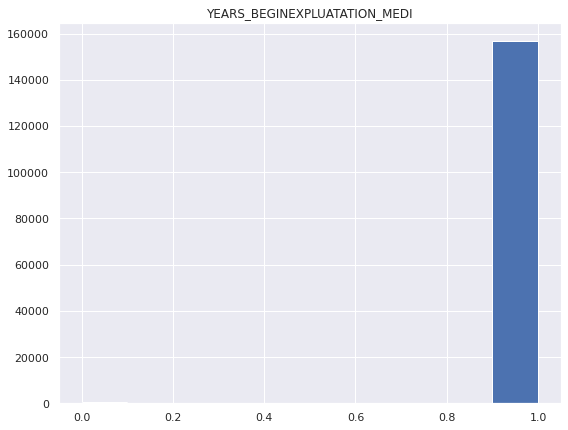

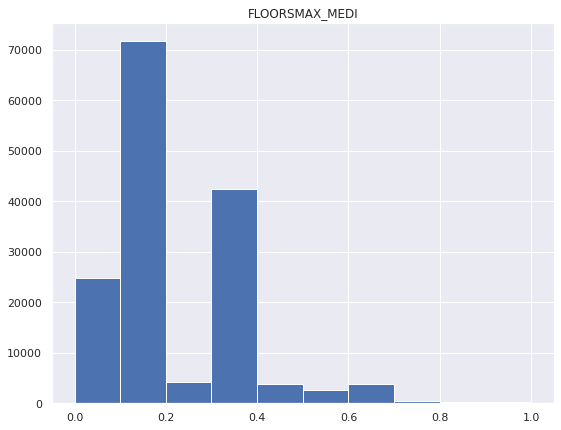

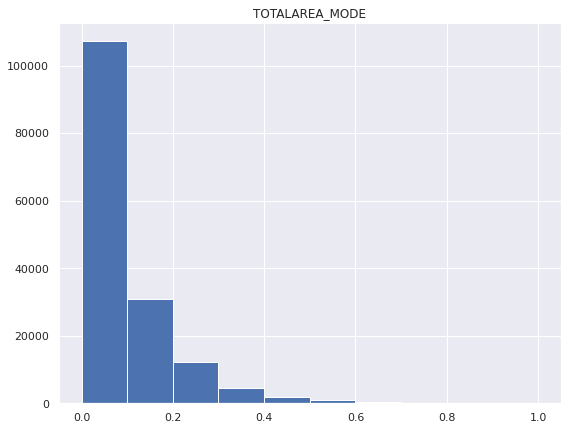

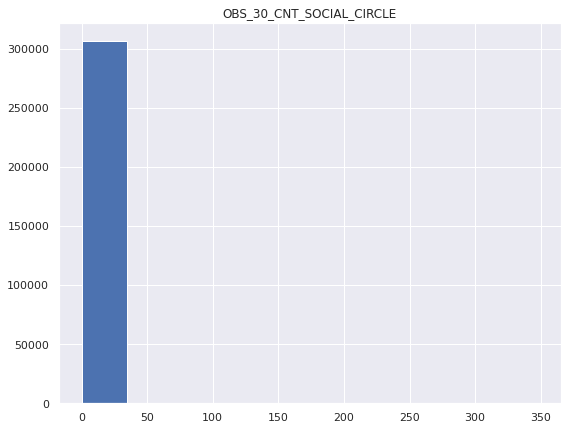

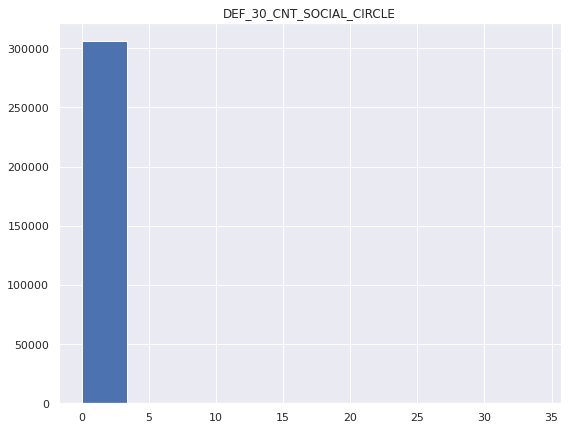

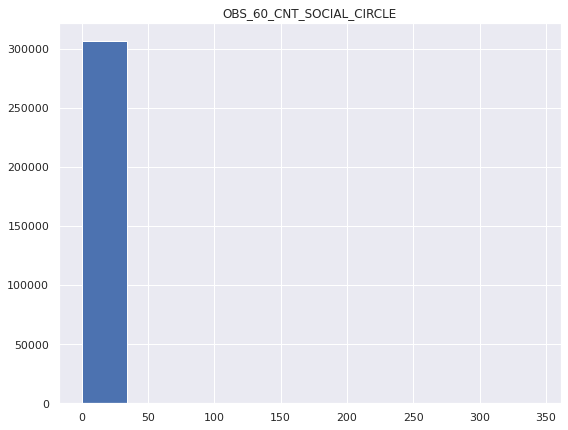

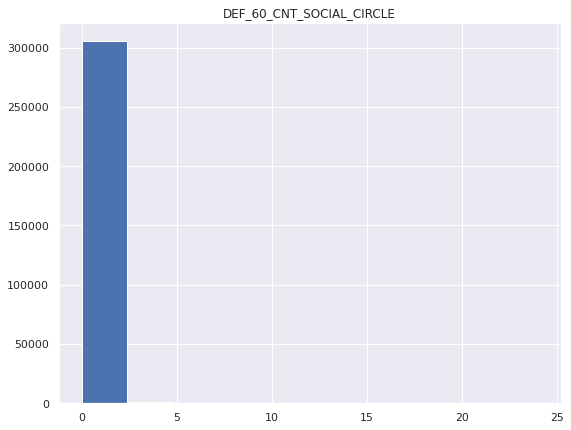

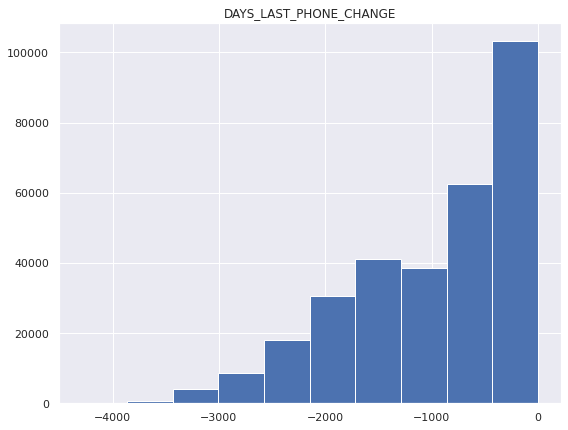

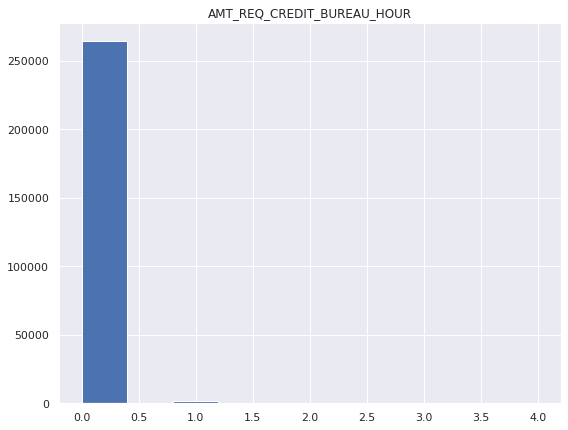

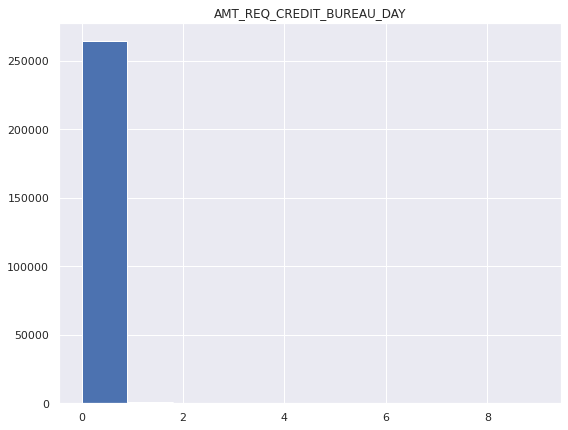

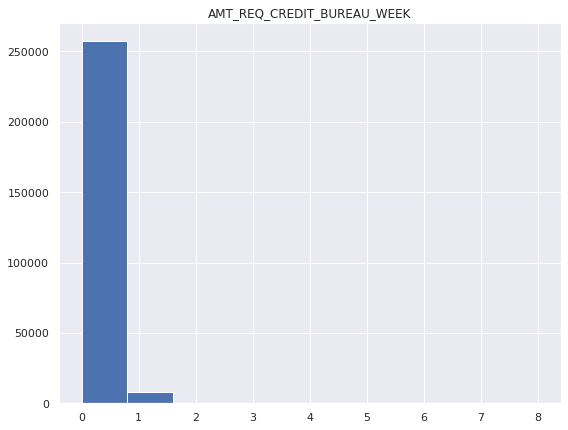

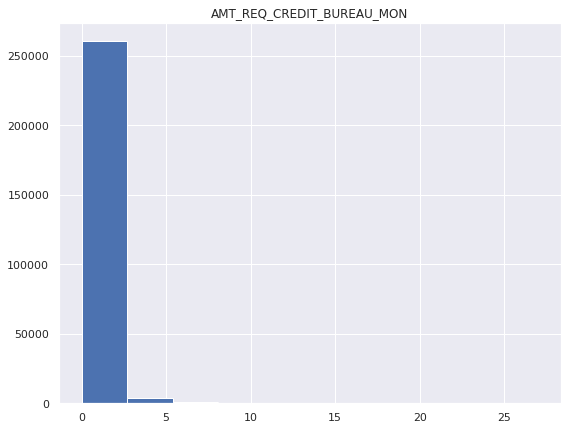

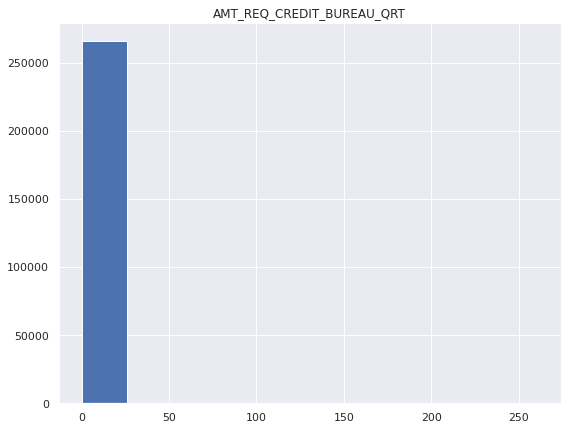

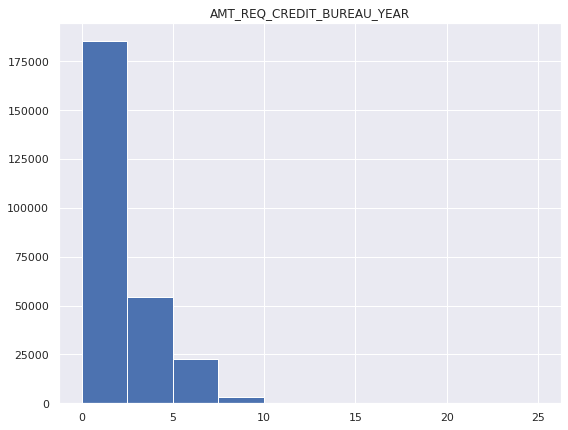

In [ ]:
warnings.filterwarnings('ignore')
for col in app_train[numerical_columns_anomal]:
 fig1, ax1 = plt.subplots()
 ax1.set_title(col)
 plt.figsize = (20,20)
 ax1.hist(app_train[col])

Заполню пустые значения для числовых фичей

Чтобы это сделать корректно, убедимся, что те значения, которые должны быть int являются int

In [ ]:
# Списко столбцов, содерщание значения типа float
list_float_numeric = pd.DataFrame(app_train[numerical_columns].dtypes.sort_values(ascending = False) == 'float64')\
.reset_index().head(30-3)['index'].to_list()

In [ ]:
app_train[list_float_numeric].head(1)

,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_LAST_PHONE_CHANGE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,TOTALAREA_MODE,FLOORSMAX_MEDI,AMT_REQ_CREDIT_BUREAU_QRT,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_AVG,EXT_SOURCE_3,EXT_SOURCE_2,CNT_FAM_MEMBERS,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_BEGINEXPLUATATION_MEDI,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR
0,1.0,-1134.0,2.0,2.0,2.0,0.0149,0.0833,0.0,0.0833,0.9722,0.0833,0.9722,0.139376,0.262949,1.0,-3648.0,0.018801,351000.0,24700.5,406597.5,202500.0,2.0,0.9722,0.0,0.0,0.0,0.0


Сделаю столбцы :AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_LAST_PHONE_CHANGE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_WEEK, CNT_FAM_MEMBERS, DAYS_REGISTRATION, DEF_60_CNT_SOCIAL_CIRCLE, AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR
целыми

In [ ]:
# Список столбцов к преобразования (float -> int)
# Пришлось создать список, перечислив необходимые столбцы вручную, так как без анализа в лоб на смысл каждого стобца будет халатно просто
# преобразовать признак, который содежит float значения
float_to_int = ['AMT_REQ_CREDIT_BUREAU_YEAR','DAYS_LAST_PHONE_CHANGE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',\
                'OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_WEEK',\
                'CNT_FAM_MEMBERS', 'DAYS_REGISTRATION', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_HOUR']

Не удалось преобразовать, так как есть *Nan* значения, которые считаются за *float* и не могут быть преображены к *int*. В начале, я хотел заполнить пропуски мидианой каждого столбца (в дипломной работе рассмотрю иные способы заполнения). Перед этим, необходимо избавиться от выбросов и аномалий. Забегая наперед, на этапе чистки аномалий, моя функция для чистки аномалий не позволяла удалять строки, содержащие эти значения из-за Nan значений. Сейчас, когда мне уже необходимо сдавать работу я понял как решить проблему, но увы времени не остается. Я учту данный аспект когда вернусь к данным при написания дипломной работы и сделаю правильно

А пока, просто удалю строки с пропусками

In [ ]:
app_train = app_train.dropna()

In [ ]:
app_train.isnull().sum().sort_values(ascending = False)

AMT_REQ_CREDIT_BUREAU_YEAR    0
AMT_REQ_CREDIT_BUREAU_QRT     0
FLAG_EMP_PHONE                0
FLAG_WORK_PHONE               0
FLAG_CONT_MOBILE              0
                             ..
FLAG_DOCUMENT_2               0
FLAG_DOCUMENT_3               0
FLAG_DOCUMENT_4               0
FLAG_DOCUMENT_5               0
SK_ID_CURR                    0
Length: 80, dtype: int64

С пропущенными значениями закончил. Можно переходить к чистке аномалий или выбросов

Чистка аномальных значений для числовых признаков

In [ ]:
# Метод чистки описан в поспроводительной записке 
def clean_outlier_anomaly(df_func, whattoclean,columns):
    # Чистка аномалий 
    if whattoclean == 'anomaly':
        for i in range(len(columns)):
            IQR = np.quantile(df_func[columns[i]],0.75) - np.quantile(df_func[columns[i]],0.25)
            return df_func[(df_func[columns[i]] < (np.quantile(df_func[columns[i]],0.75) + 3*IQR))
                              & 
                              (df_func[columns[i]] > (np.quantile(df_func[columns[i]],0.25) - 3*IQR))]
    # Чистка выбросов
    if whattoclean == 'outlier':
        for i in range(len(columns)):
            IQR = np.quantile(df_func[columns[i]],0.75) - np.quantile(df_func[columns[i]],0.25)
            return df_func[(df_func[columns[i]] < (np.quantile(df_func[columns[i]],0.75) +1.5*IQR))
                           & 
                           (df_func[columns[i]] > (np.quantile(df_func[columns[i]],0.25) - 1.5*IQR))]

In [ ]:
app_train.shape[0],app_train.shape[1]

(123442, 80)

Удаление аномалии для всех признаков, которые я отобрал для чистки прививодит к тому, что датасет станет пустым, поэтому удалю аномальные значения только для некоторых столбцов.

In [ ]:
app_train = clean_outlier_anomaly(df_func = app_train, whattoclean = 'anomaly', columns = ['CNT_FAM_MEMBERS'])
app_train = clean_outlier_anomaly(df_func = app_train, whattoclean = 'anomaly', columns = ['CNT_CHILDREN'])
app_train = clean_outlier_anomaly(df_func = app_train, whattoclean = 'anomaly', columns = ['AMT_INCOME_TOTAL'])
app_train = clean_outlier_anomaly(df_func = app_train, whattoclean = 'anomaly', columns = ['AMT_CREDIT'])
app_train = clean_outlier_anomaly(df_func = app_train, whattoclean = 'anomaly', columns = ['AMT_REQ_CREDIT_BUREAU_YEAR'])
app_train = clean_outlier_anomaly(df_func = app_train, whattoclean = 'anomaly', columns = ['DAYS_EMPLOYED'])
app_train = clean_outlier_anomaly(df_func = app_train, whattoclean = 'anomaly', columns = ['AMT_REQ_CREDIT_BUREAU_YEAR'])

In [ ]:
app_train.shape[0],app_train.shape[1]

(99141, 80)

### Correlation

In [ ]:
CorrKoef = app_train.corr()

In [ ]:
CorField = []
for i in CorrKoef:
  
  for j in CorrKoef.index[(CorrKoef[i] > 0.8) | (CorrKoef[i] < -0.8)]:

    
    if i != j and j not in CorField and i not in CorField:

      CorField.append(j)
      print( "%s --> %s: Corr = %f" % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

CNT_CHILDREN --> CNT_FAM_MEMBERS: Corr = 0.876452
AMT_CREDIT --> AMT_GOODS_PRICE: Corr = 0.986177
REGION_RATING_CLIENT --> REGION_RATING_CLIENT_W_CITY: Corr = 0.925985
REG_REGION_NOT_WORK_REGION --> LIVE_REGION_NOT_WORK_REGION: Corr = 0.882434
REG_CITY_NOT_WORK_CITY --> LIVE_CITY_NOT_WORK_CITY: Corr = 0.865530
YEARS_BEGINEXPLUATATION_AVG --> YEARS_BEGINEXPLUATATION_MODE: Corr = 0.949908
YEARS_BEGINEXPLUATATION_AVG --> YEARS_BEGINEXPLUATATION_MEDI: Corr = 0.984250
FLOORSMAX_AVG --> FLOORSMAX_MODE: Corr = 0.985459
FLOORSMAX_AVG --> FLOORSMAX_MEDI: Corr = 0.997050
OBS_30_CNT_SOCIAL_CIRCLE --> OBS_60_CNT_SOCIAL_CIRCLE: Corr = 0.998755
DEF_30_CNT_SOCIAL_CIRCLE --> DEF_60_CNT_SOCIAL_CIRCLE: Corr = 0.863264


In [ ]:
app_train.shape[0],app_train.shape[1]

(99141, 80)

#### Удалю признаки с корреляцией > **0.8**
#### Не сущевствует канонического значения корреляции, зафиксировав которое, необходимо сразу же удалить признак, поэтому я ввел данный порог основываясь на опыт статье и блогов по ML

In [ ]:
app_train = app_train.drop(CorField, axis = 1)

In [ ]:
app_train.shape[0],app_train.shape[1]

(99141, 69)

### Преобразование категориальных признаков 

In [ ]:
app_train.shape[0],app_train.shape[1]

(99141, 69)

In [ ]:
app_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [ ]:
# удалю строки с бессмысленным для столбца значение
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

In [ ]:
app_train.shape[0],app_train.shape[1]

(99138, 69)

Теперь необходимо удалить столбцы, заполнить пропущенные значения, преобразовать тип данных столбцов и т.д. для app_test, чтобы количество столбцов, было на N-1 как у train

In [ ]:
app_test = pd.read_csv('drive/MyDrive/Data/application_test.csv')

In [ ]:
app_test = app_test.drop(missing_list, axis = 1)

In [ ]:
dict_pop =  {'NAME_TYPE_SUITE':app_test['NAME_TYPE_SUITE'].value_counts().sort_values(ascending = False).index[0],
              'OCCUPATION_TYPE':app_test['OCCUPATION_TYPE'].value_counts().sort_values(ascending = False).index[0],
              'EMERGENCYSTATE_MODE':app_test['EMERGENCYSTATE_MODE'].value_counts().sort_values(ascending = False).index[0]}

In [ ]:
dict_pop

{'EMERGENCYSTATE_MODE': 'No',
 'NAME_TYPE_SUITE': 'Unaccompanied',
 'OCCUPATION_TYPE': 'Laborers'}

In [ ]:
app_test = app_test.fillna(value = dict_pop)

In [ ]:
app_test = app_test.drop('DAYS_ID_PUBLISH', axis = 1)

In [ ]:
float_to_int = ['AMT_REQ_CREDIT_BUREAU_YEAR','DAYS_LAST_PHONE_CHANGE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',\
                'OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_WEEK',\
                'CNT_FAM_MEMBERS', 'DAYS_REGISTRATION', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_HOUR']

In [ ]:
app_test = app_test.dropna()

In [ ]:
app_test[float_to_int] = app_test[float_to_int].astype('int64')

In [ ]:
app_test = clean_outlier_anomaly(df_func = app_test, whattoclean = 'anomaly', columns = ['CNT_FAM_MEMBERS'])
app_test = clean_outlier_anomaly(df_func = app_test, whattoclean = 'anomaly', columns = ['CNT_CHILDREN'])
app_test = clean_outlier_anomaly(df_func = app_test, whattoclean = 'anomaly', columns = ['AMT_INCOME_TOTAL'])
app_test = clean_outlier_anomaly(df_func = app_test, whattoclean = 'anomaly', columns = ['AMT_CREDIT'])
app_test = clean_outlier_anomaly(df_func = app_test, whattoclean = 'anomaly', columns = ['AMT_REQ_CREDIT_BUREAU_YEAR'])
app_test = clean_outlier_anomaly(df_func = app_test, whattoclean = 'anomaly', columns = ['DAYS_EMPLOYED'])
app_test = clean_outlier_anomaly(df_func = app_test, whattoclean = 'anomaly', columns = ['AMT_REQ_CREDIT_BUREAU_YEAR'])

In [ ]:
app_test = app_test.drop(CorField, axis = 1)

In [ ]:
app_test.shape[0], app_test.shape[1]

(16373, 68)

In [ ]:
print(f'Количество признаков train: {app_train.shape[1]}  Количество признаков test: {app_test.shape[1]}')

Количество признаков train: 69  Количество признаков test: 68


In [ ]:
# Перед преобразованием я сделаю копию датасета для модели catboost, которая самостоятельно преобразуют категориальные признаки
app_test_with_categ = app_test.copy()
app_train_with_categ = app_train.copy()

In [ ]:
app_test_with_categ.to_csv('X_test_.csv',
                            header = True,sep = ';') 

In [ ]:
app_train_with_categ.to_csv('X_train_.csv',
                             header = True,sep = ';') 

In [ ]:
# список категориальных столбцов для преобразования
# собрал данный список из теста, а не отдельно для train и test, так я уже сделал все, чтобы оба датафрейма хранили одинаковые столбца (за исключеним TARGET у test)
categorical_columns_to_convert = [column for column in app_test.columns if app_test[column].dtype == 'object']

In [ ]:
# Метод (OneHotEncoder) преобразования описан в спороводительной записке 
class My_encoder(BaseEstimator, TransformerMixin):
   
    def __init__(self,drop = 'first',sparse=False):
        self.encoder = OneHotEncoder(drop = drop,sparse = sparse)
        self.features_to_encode = []
        self.columns = []
    
    def fit(self,X_train,features_to_encode):
        
        data = X_train.copy()
        self.features_to_encode = features_to_encode
        data_to_encode = data[self.features_to_encode]
        self.columns = pd.get_dummies(data_to_encode,drop_first = True).columns
        self.encoder.fit(data_to_encode)
        return self.encoder
    
    def transform(self,X_test):
        
        data = X_test.copy()
        data.reset_index(drop = True,inplace =True)
        data_to_encode = data[self.features_to_encode]
        data_left = data.drop(self.features_to_encode,axis = 1)
        
        data_encoded = pd.DataFrame(self.encoder.transform(data_to_encode),columns = self.columns)
        
        return pd.concat([data_left,data_encoded],axis = 1)

In [ ]:
X_train_ = app_train

In [ ]:
X_test_ = app_test

In [ ]:
# Преобразование категориальных столбцов 
features_to_encode = categorical_columns_to_convert
enc = My_encoder()
enc.fit(X_train_,features_to_encode)
X_train_one_hoted = enc.transform(X_train_)
X_test_one_hoted = enc.transform(X_test_)

In [ ]:
# Дополнительная провека на пропуски
missing_values_table(X_train_one_hoted,flag = False,percent = 0)

,Missing Values,% of Total Values


In [ ]:
missing_values_table(X_train_one_hoted,flag = False,percent = 0)

,Missing Values,% of Total Values


In [ ]:
# Проверка на наличие категориальных признаков
X_train_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99138 entries, 0 to 99137
Columns: 164 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(127), int64(37)
memory usage: 124.0 MB


In [ ]:
# Проверка на наличие категориальных признаков
X_test_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16373 entries, 0 to 16372
Columns: 163 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(117), int64(46)
memory usage: 20.4 MB


##### Удалю столбец **SK_ID_CURR** - id кредита. Может показаться, что данный столбец можно воспринимать как id заемщика. Однако, клиент мог ранее брать (рассматриваю train) не один кредит, и у каждого кредита свой id. Информации о том, какой заемщик брал кредит с **SK_ID_CURR** например 227 у меня нет, следовательно, каждый **SK_ID_CURR** - просто уникальное значение...

In [ ]:
# Количество строк всего датасета
len(X_train_one_hoted)

99138

In [ ]:
# Собрал уникальные значения столбца SK_ID_CURR, затем длину данного списка, чтобы убедиться с выше сказанным
len(X_train_one_hoted['SK_ID_CURR'].unique())

99138

##### Для test (текущие заявки на получение кредита) гипотеза также применима...

In [ ]:
len(X_test_one_hoted)

16373

In [ ]:
len(X_test_one_hoted['SK_ID_CURR'].unique())

16373

In [ ]:
# Удалю SK_ID_CURR у test и train
X_test_one_hoted = X_test_one_hoted.drop("SK_ID_CURR", axis = 1)
X_train_one_hoted = X_train_one_hoted.drop("SK_ID_CURR", axis = 1)

##### Я не стал проводить нормализацию или стандартизацию сейчас, с целью это сделать после того, как я выберу лучшую модель. На сколько я знаю, во многих случаях стоит проводить данные процедуры, но, я захотел лично убедиться в необходимости этого после построения модели без, например нормализации и с нормализацией, результируая  метриками классификаторов

##### Также, я не стал применять понижение размерности на данном этапе, так решил провести это в дипломной работе, в качестве изучание данной процедуры и выбора такого алгоритма, который сохранит интерпретируемость модели в дальнейшем.


##### Обучать модель и оценивать ее качество метриками, я буду только на датафрейме train, разбив его на test и train. А делать конечное предсказание на датафрейм test

In [ ]:
# Разделение данных на тренировочные и тестовые. Размер разбиения - пока что самый распространенный
X_train, X_test, y_train, y_test = train_test_split(X_train_one_hoted.drop("TARGET", axis = 1),
                                                    X_train_one_hoted["TARGET"], test_size=0.3, random_state = 42)

###Выбор модели с базовыми параметрами

##### На данном этапе развития как специалиста, я не могу жанглировать знаниями о каждой модели, и обоснованно взять на рассмотрение только 3 модели, которые лучше поймут данные и на практике и опыту людей, лучше подходят к области (как в моем случае - кридитного скоринга), а не 10, что сэкономит время. Однако, я хочу подготовить  модель, которая точнее будет прогнозировать *Y* и придется обучать 10 моделью.

###Метрики

#####  Я не буду рассматривать **Accuracy**, так как данная метрика не подходит для несбалансированных классов (несбалансированность я обнаружил в начале работы, изобразив с помощью круговой диаграммы).
##### **ROC AUC** больше подходит для подобных данных, однако не панацея. Однако я буду основываться на данную метрику
##### Большую часть внимания я уделю метрикам **Recall**, **Precision**, т.к. присуствует несбалансированность. Данное явление является проблемой, так как обощение модели сводится в сторону мажорного класса.
##### Я возьму **F-Score**, т.к. данная метрика придает одинаковый вес точности и полноте. F-Score будет падать одинаково при уменьшении и точности и полноты.


In [ ]:
models = [
          xgb.XGBClassifier(random_state=42),
          CatBoostClassifier(random_state=42),
          lgb.LGBMClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=42),
          LogisticRegression(random_state=42),
          GaussianNB(),
          SVC(probability=True, random_state=42),
          MLPClassifier(random_state=42),
          GradientBoostingClassifier(random_state=42),
          RidgeClassifier(random_state=42),
          SGDClassifier(random_state=42)
          ]

In [ ]:
# Функция, которая обучает модели, выводит значение ROC AUC и классификацинный репорт (значений f1, recall, precision) и строит график площади ROC AUC
def train_models(models, X_train,X_test, y_train, y_test):

 
  accurancy_list = []
  auc_list = []
  best_model = 0
  best_score = 0
  best_roc_auc_score = 0
  
  for name_model in models:
    model = name_model.fit(X_train, y_train)
    if isinstance(name_model,DecisionTreeClassifier):
      roc_auc_score1 = roc_auc_score(y_test,name_model.predict(X_test))
    elif isinstance(name_model,SVC):
      roc_auc_score1 = roc_auc_score(y_test,name_model.decision_function(X_test))
    elif isinstance(name_model,RidgeClassifier):
      roc_auc_score1 = roc_auc_score(y_test,name_model.decision_function(X_test)) 
    elif isinstance(name_model,SGDClassifier):
      roc_auc_score1 = roc_auc_score(y_test,name_model.decision_function(X_test)) 
    else:
      probs = model.predict_proba(X_test)
      probs = probs[:, 1]
      roc_auc_score1 = roc_auc_score(y_test,probs)

    auc_list.append(roc_auc_score1)
  
    report = classification_report(y_test, model.predict(X_test))
    
    print(f' Модель: {name_model} ')
    print(' ')
    print(f' roc_auc_score :{roc_auc_score1}')
    print(' ')
    print(f' Report {report}')
    print(' ')
    print(' ')
  
    if isinstance(name_model,DecisionTreeClassifier):
      probs = name_model.predict(X_test)
      fpr , tpr , _ = roc_curve(y_test, probs)
      plt.figure()
      lw = 2
      plt.plot(fpr, tpr, color='darkorange',
      lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC AUC {name_model}')
      plt.legend(loc="lower right")
      plt.grid()

    elif isinstance(name_model,RidgeClassifier):

      probs = name_model.decision_function(X_test)
      fpr , tpr , _ = roc_curve(y_test, probs)
      plt.figure()
      lw = 2
      plt.plot(fpr, tpr, color='darkorange',
      lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC AUC {name_model}')
      plt.legend(loc="lower right")
      plt.grid()
  
  
    elif isinstance(name_model,SGDClassifier):
  
  
      probs = name_model.decision_function(X_test)
      fpr , tpr , _ = roc_curve(y_test, probs)
      plt.figure()
      lw = 2
      plt.plot(fpr, tpr, color='darkorange',
      lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC AUC {name_model}')
      plt.legend(loc="lower right")
      plt.grid()
 
    else:

      probs = name_model.predict_proba(X_test)
      probs = probs[:, 1]
      fpr , tpr , _ = roc_curve(y_test, probs)
      plt.figure()
      lw = 2
      plt.plot(fpr, tpr, color='darkorange',
      lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC AUC {name_model}')
      plt.legend(loc="lower right")
      plt.grid()
  # print(f'У {models[accurancy_list.index(max(accurancy_list))]} самый большой Accuracy и {}')

 Модель: XGBClassifier(random_state=42) 
 
 roc_auc_score :0.7414783553645284
 
 Report               precision    recall  f1-score   support

           0       0.92      1.00      0.96     27500
           1       0.50      0.00      0.01      2242

    accuracy                           0.92     29742
   macro avg       0.71      0.50      0.48     29742
weighted avg       0.89      0.92      0.89     29742

 
 
Learning rate set to 0.062977
0:	learn: 0.6220811	total: 84.8ms	remaining: 1m 24s
1:	learn: 0.5634505	total: 113ms	remaining: 56.4s
2:	learn: 0.5170030	total: 137ms	remaining: 45.5s
3:	learn: 0.4750768	total: 177ms	remaining: 44.1s
4:	learn: 0.4407229	total: 201ms	remaining: 40s
5:	learn: 0.4106566	total: 226ms	remaining: 37.4s
6:	learn: 0.3850899	total: 257ms	remaining: 36.5s
7:	learn: 0.3623232	total: 285ms	remaining: 35.3s
8:	learn: 0.3452880	total: 310ms	remaining: 34.1s
9:	learn: 0.3313534	total: 336ms	remaining: 33.2s
10:	learn: 0.3195105	total: 362ms	remaining: 32.5s


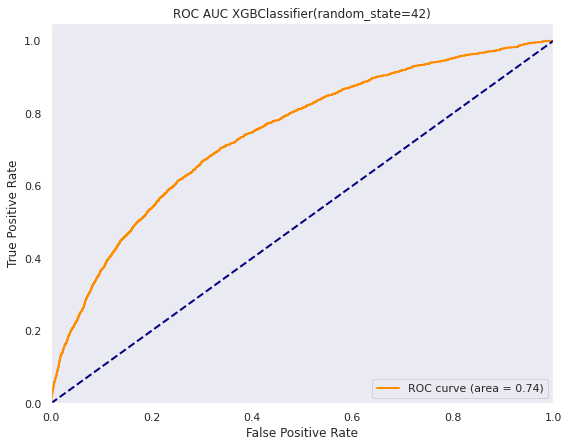

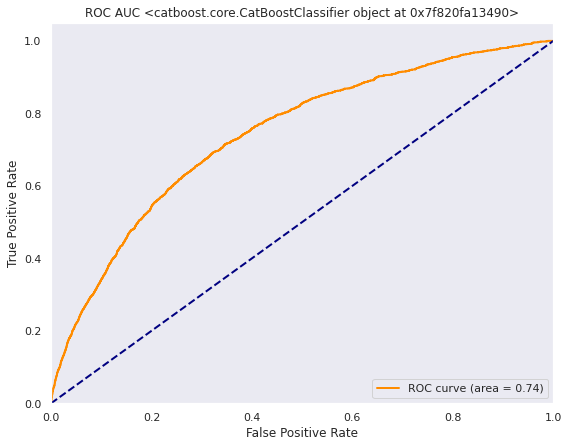

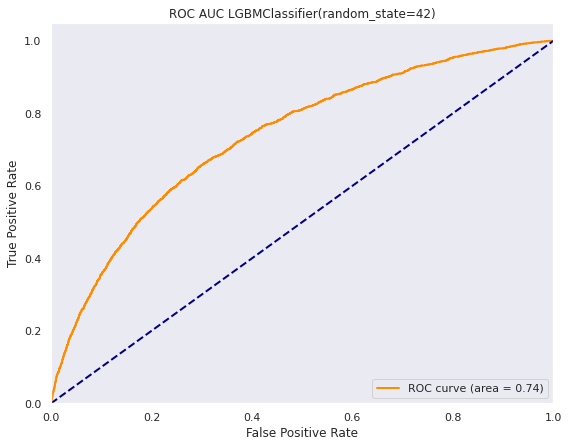

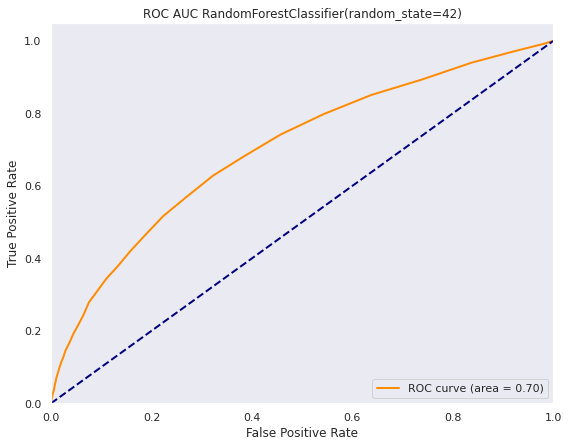

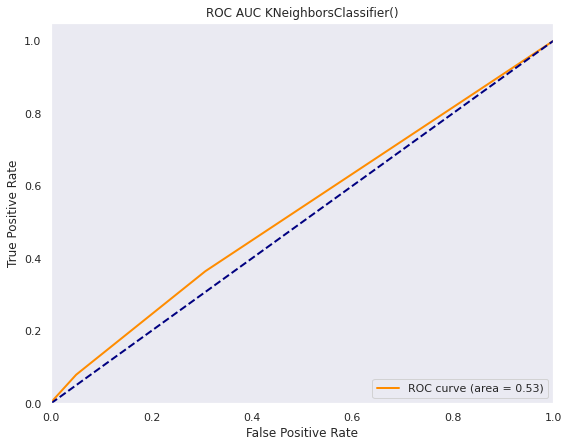

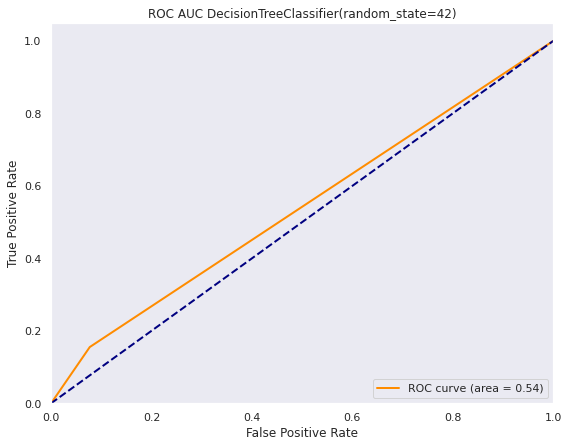

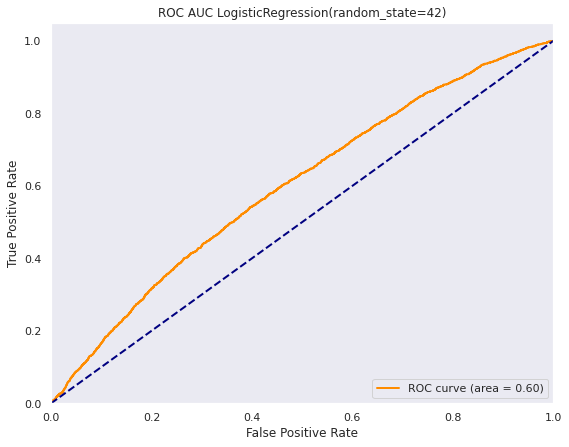

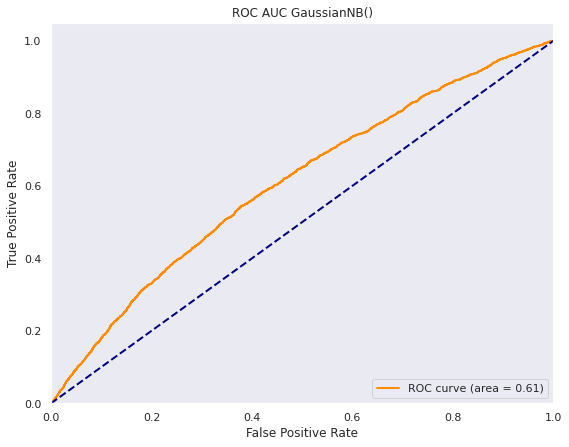

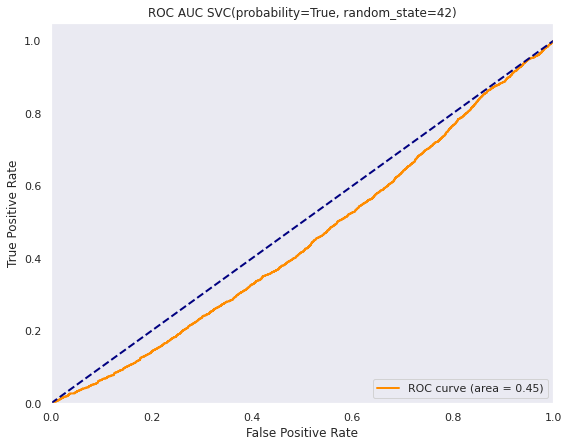

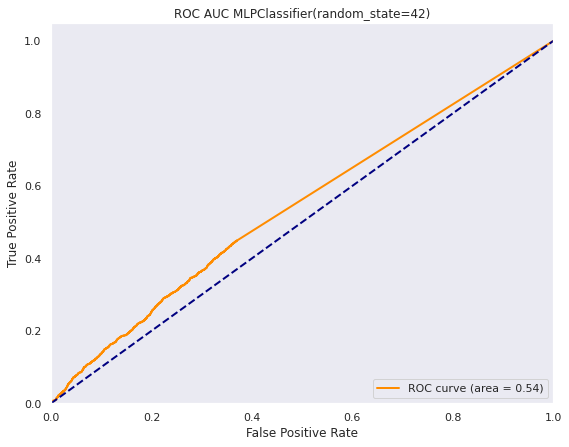

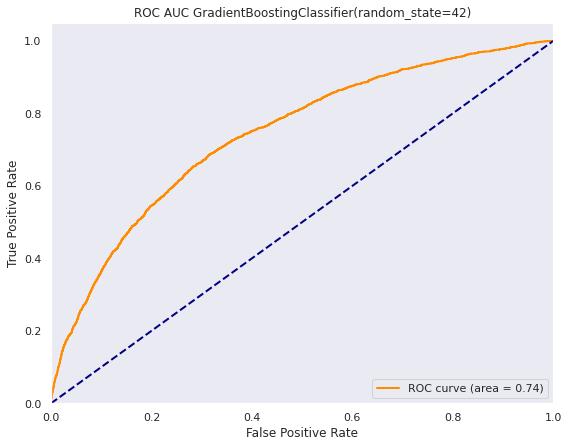

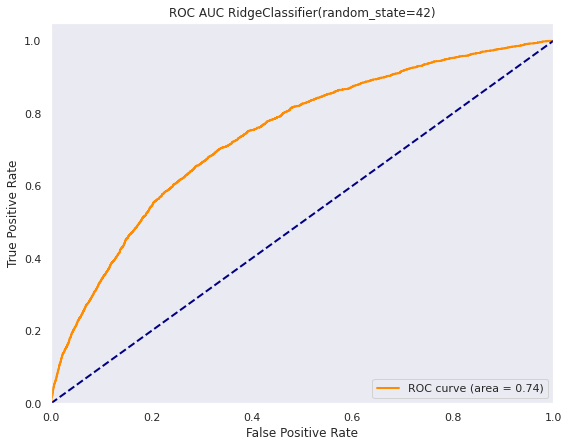

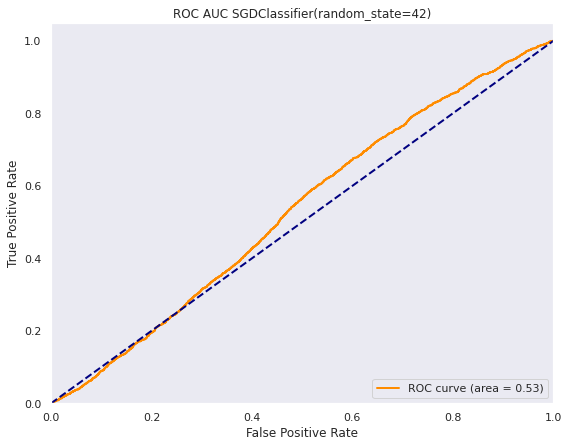

In [ ]:
train_models(models,X_train, X_test, y_train, y_test)

#### В итоге, модели показали отврательный результат...

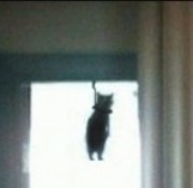

#### Анализируя *Recall* и *Precision* видно, что минорный класс практический **не распознан**. Глобально, все из-за несбалонсированности классов.

#### Минорный класс составляют заемщики, которые совершили просрочку или не вернули долг. Необходимо попытаться побороть дизбаланс и улучшить предсказательную способность модели минорного класса потому, что точно предсказать проблемы по платежам и полный невозрат гораздо важнее, ибо убытки на сумму выдачи кредита + упущенная прибыль в виде процентов принесет больше убытков банку, чем просто упущенная прибыль по процентам.

#### Так как ни одна модель не показала удолетворительный результат, я просто выберу ***CatBoost***. Есть резон попробовать использовать грандиентный бустинг по таким субъективным причинам как опыт людей, советующих не редко CatBoost, решая задачи предсказания дефолта заемщика и собственное желание изучить данную модель.

# Далее попытаюсь бороть дисбаланс классов, проведу кросс-валидацию, грид серч, тюнинг и интрепретацию модели в **другом ноутбуке** (Курсовая работа Часть 2.ipynb), заранее подготовив данные, так как CatBoost'ские визуализации при обучение не отоброжаются в Colab, а мне хотелось бы видеть этапы работы в реальном времени

### НИЖЕ РАБОТА С SUB TABLES (ДЛЯ ДИПЛОМА)

In [ ]:
# for i in range(0,len(description)):
#   print(description[description['Table'] == 'application_{train|test}.csv']['Row'].iloc[i] +'  :  '+ description[description['Table'] == 'application_{train|test}.csv']['Description'].iloc[i])

In [ ]:
description

Все таблицы:

In [ ]:
description = pd.read_csv('drive/MyDrive/Data/HomeCredit_columns_description.csv', encoding= 'windows-1251')
sample_submission = pd.read_csv('drive/MyDrive/Data/sample_submission.csv')
application_train = pd.read_csv('drive/MyDrive/Data/application_train.csv')
previous_application = pd.read_csv('drive/MyDrive/Data/previous_application.csv')
installments_payments = pd.read_csv('drive/MyDrive/Data/installments_payments.csv')
credit_card_balance = pd.read_csv('drive/MyDrive/Data/credit_card_balance.csv')
bureau_balance = pd.read_csv('drive/MyDrive/Data/bureau_balance.csv')
bureau = pd.read_csv('drive/MyDrive/Data/bureau.csv')
pos_cash_balance = pd.read_csv('drive/MyDrive/Data/POS_CASH_balance.csv')

In [ ]:
description.name = 'description'
sample_submission.name = 'sample_submission'
application_train.name = 'application_train'
application_test.name = 'application_test'
previous_application.name = 'previous_application'
installments_payments.name = 'installments_payments'
credit_card_balance.name = 'credit_card_balance'
bureau_balance.name = 'bureau_balance'
bureau.name = 'bureau'
pos_cash_balance.name = 'pos_cash_balance'

In [ ]:
all_tables = [sample_submission, application_train, application_test, previous_application, installments_payments, credit_card_balance, bureau_balance, bureau, pos_cash_balance]
all_tables_name = []
for t in all_tables:
  all_tables_name.append(t.name)


Поиск интересных фич у дополнительных таблиц

installments_payments. Тут хранится инфа о том, когда клинет по дате должен был выплатить кредит и когда он сделал это фактически + какую сумму должен и сколько фактически оплатил.

Поробовать сделать из этого 2 столбца?

" История погашения ранее выданных кредитов в Хоум Кредит, связанных с кредитами в нашей выборке.
"Существует а) одна строка для каждого произведенного платежа плюс б) по одной строке для каждого пропущенного платежа.
"Одна строка эквивалентна одному платежу одним взносом ИЛИ одному платежу, соответствующему одному платежу одного предыдущего кредита на покупку жилья, связанного с кредитами в нашей выборке.

In [ ]:
for i in range(0,8):
  print(description[description['Table'] == 'installments_payments.csv']['Row'].iloc[i] +'  :  '+ description[description['Table'] == 'installments_payments.csv']['Description'].iloc[i])

In [ ]:
installments_payments.isnull().sum()

In [ ]:
installments_payments[installments_payments['SK_ID_PREV'] == 2085231].sum()

In [ ]:
previous_application_v2[previous_application_v2['SK_ID_PREV'] == 2085231 ]

In [ ]:
installments_payments_ver2 = installments_payments.copy()

###previous_application


Все предыдущие заявки на ипотечные кредиты клиентов, у которых есть кредиты в нашей выборке.
В нашей выборке данных есть одна строка для каждой предыдущей заявки, связанной с кредитами.

In [ ]:
for i in range(0,38):
  print(description[description['Table'] == 'previous_application.csv']['Row'].iloc[i] +'  :  '+ description[description['Table'] == 'previous_application.csv']['Description'].iloc[i])

##### В результате анализа таблицы на придмет признаков, которые стоит исключить из иследования, было выявлено X столбцов из Y в данной таблице. Данные столбцы были исключены по признакам избыточного количества пропусков и из соображений снизить объем для входных данных модели. Наибольшие количество столбцов, которые были приняты на удаление содержали данные по типу: с помощью каких ресурсов был привлечен клиент, во сколько часов было принято решение по заявке, в какой день недели, сколько раз клиент отправлял данную заявку (в описание данных указано, что такое могло происходить по причине неполадки сервиса), сумма, которую выдал банк и заявленная клиентом цена на товар (чаще всего, числа были либо одинаковые, либо с небольшой разницей). Безусловно, часть удаленных признаков могли послужить для клиентской аналитки, филиалов и прочего, но они не столько важны для данного исследования


In [ ]:
previous_application_v2 = previous_application.copy()

In [ ]:
previous_application_v2 = previous_application.drop(['AMT_ANNUITY', 'AMT_APPLICATION','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','FLAG_LAST_APPL_PER_CONTRACT','NFLAG_LAST_APPL_IN_DAY','RATE_INTEREST_PRIMARY',
'RATE_INTEREST_PRIVILEGED','DAYS_DECISION','NAME_PAYMENT_TYPE','CODE_REJECT_REASON','NAME_TYPE_SUITE','NAME_CLIENT_TYPE', 'NAME_PRODUCT_TYPE','CHANNEL_TYPE','SELLERPLACE_AREA','NAME_SELLER_INDUSTRY','NAME_YIELD_GROUP','PRODUCT_COMBINATION',], axis = 1)

In [ ]:
2085231

In [ ]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,...

In [ ]:
Подумать о том, соединять ли первые 2 таблицы или нет

### credit_card_balance

#### Ежемесячные снимки баланса предыдущих кредитных карт, которые заявитель имеет с Home Credit.
#### В этой таблице есть одна строка для каждого месяца истории каждого предыдущего кредита в Home Credit (потребительский кредит и кредиты наличными), связанные с кредитами в нашей выборке, т. Е. в таблице есть (#кредиты в выборке *# относительных предыдущих кредитных карт * # месяцев, в которых у нас есть некоторая история, наблюдаемая для предыдущей кредитной карты) строк.

In [ ]:
for i in range(0,23):
  print(description[description['Table'] == 'credit_card_balance.csv']['Row'].iloc[i] +'  :  '+ description[description['Table'] == 'credit_card_balance.csv']['Description'].iloc[i])

SK_ID_PREV   :  ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
SK_ID_CURR  :  ID of loan in our sample
MONTHS_BALANCE  :  Month of balance relative to application date (-1 means the freshest balance date)
AMT_BALANCE  :  Balance during the month of previous credit
AMT_CREDIT_LIMIT_ACTUAL  :  Credit card limit during the month of the previous credit
AMT_DRAWINGS_ATM_CURRENT  :  Amount drawing at ATM during the month of the previous credit
AMT_DRAWINGS_CURRENT  :  Amount drawing during the month of the previous credit
AMT_DRAWINGS_OTHER_CURRENT  :  Amount of other drawings during the month of the previous credit
AMT_DRAWINGS_POS_CURRENT  :  Amount drawing or buying goods during the month of the previous credit
AMT_INST_MIN_REGULARITY  :  Minimal installment for this month of the previous credit
AMT_PAYMENT_CURRENT  :  How much did the client pay during the month on the previous credit
AMT_P

In [ ]:
credit_card_balance.isnull().sum()/len(credit_card_balance)*100

SK_ID_PREV                     0.000000
SK_ID_CURR                     0.000000
MONTHS_BALANCE                 0.000000
AMT_BALANCE                    0.000000
AMT_CREDIT_LIMIT_ACTUAL        0.000000
AMT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_CURRENT           0.000000
AMT_DRAWINGS_OTHER_CURRENT    19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
AMT_INST_MIN_REGULARITY        7.948208
AMT_PAYMENT_CURRENT           19.998063
AMT_PAYMENT_TOTAL_CURRENT      0.000000
AMT_RECEIVABLE_PRINCIPAL       0.000000
AMT_RECIVABLE                  0.000000
AMT_TOTAL_RECEIVABLE           0.000000
CNT_DRAWINGS_ATM_CURRENT      19.524872
CNT_DRAWINGS_CURRENT           0.000000
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_POS_CURRENT      19.524872
CNT_INSTALMENT_MATURE_CUM      7.948208
NAME_CONTRACT_STATUS           0.000000
SK_DPD                         0.000000
SK_DPD_DEF                     0.000000
dtype: float64

### pos_cash_balance

Ежемесячные снимки баланса предыдущих POS (точек продаж) и кредитов наличными, которые заявитель имел с помощью Home Credit.
В этой таблице есть одна строка для каждого месяца истории каждого предыдущего кредита в Home Credit (потребительский кредит и кредиты наличными), связанные с кредитами в нашей выборке, т. Е. в таблице есть (#кредиты в выборке * # относительных предыдущих кредитов * # месяцев, в которых у нас есть некоторая история, наблюдаемая для предыдущих кредитов) строк.

In [ ]:

for i in range(0,8):
  print(description[description['Table'] == 'POS_CASH_balance.csv']['Row'].iloc[i] +'  :  '+ description[description['Table'] == 'POS_CASH_balance.csv']['Description'].iloc[i])

SK_ID_PREV   :  ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
SK_ID_CURR  :  ID of loan in our sample
MONTHS_BALANCE  :  Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
CNT_INSTALMENT  :  Term of previous credit (can change over time)
CNT_INSTALMENT_FUTURE  :  Installments left to pay on the previous credit
NAME_CONTRACT_STATUS  :  Contract status during the month
SK_DPD  :  DPD (days past due) during the month of previous credit
SK_DPD_DEF  :  DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit
